<center><img src="https://pbs.twimg.com/media/FommiJ9WIAEBPI0.jpg" width="500" /></center>
    
 <center> 

# Fase local
## Script de exploración - Equipo **Malbecs**

</center>

**Integrantes**

- Denis Trosman
- Vito Stamatti
- Sumit Kumar Jethani

# Objetivo

España es el tercer productor mundial de vino. Disponer de una previsión precisa de la producción en una campaña agrícola es cada vez más necesario de cara a optimizar todos los procesos de la cadena: recolección, traslado, procesado, almacenamiento y distribución.

Dado lo anterior y partiendo de amplios datasets con histórico de producciones de los viñedos que conforman la cooperativa La Viña, así como histórico de la climatología de los mismos, intentaremos crear el mejor modelo de predicción de producción de una campaña en base al cual se pueda estimar la cosecha que dispondrá la cooperativa meses antes de la recolección.

El primer paso será realizar un análisis exploratorio de los datos.

Recordemos que contamos con tres datasets:

- Train: datos históricos de las fincas.
- Meteo: datos por hora del clima.
- ETO: datos agregados del clima.

Por este motivo, el análisis exploratorio será dividido en tres partes, respectivamente.

# Importacion de librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'


#Modelos
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.preprocessing  import KBinsDiscretizer, MinMaxScaler, SplineTransformer
from catboost import CatBoostRegressor

from xgboost import XGBRegressor

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Train

El dataset contiene informacion de las siguientes variables sobre las fincas de los viñedos:

- CAMPAÑA: Año de la campaña.
- ID_FINCA: Identificador de finca.
- ID_ZONA: Identificador de una zona con una tipología de suelo común
- ID_ESTACION: Identificador de estación meteorológica.
- ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
- VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
- MODO: Código del modo de cultivo.
- TIPO: Tipo de cultivo dentro de la variedad.
- COLOR: Identificador del color de la uva.
- SUPERFICIE: Superficie en hectáreas que ocupa la finca.
- PRODUCCION: Producción en kg. Obtenida en la campaña.

## Exploración inicial

Carga de datos

In [2]:
path = 'C:/Users/denis/OneDrive/Escritorio/Datathon/datos'
df = pd.read_csv(path + '/UH_2023_TRAIN.txt', sep= '|', header=0 )

Primera visualización

In [3]:
df.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


Ajustamos nombres de columnas bajo buenas prácticas

In [4]:
df.columns = [col.lower() for col in df.columns]

Resumen general de los datos

In [5]:
print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
print(f'\nCantidad de duplicados: {df.duplicated().sum()}\n')
print('-'*30 + 'Tipos de columnas'+ '-'*30)
print(df.dtypes)
print('-'*30 + 'Cantidad de nulos' +'-'*30)
df.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

------------------------------Tipos de columnas------------------------------
campaña          int64
id_finca         int64
id_zona          int64
id_estacion      int64
altitud         object
variedad         int64
modo             int64
tipo             int64
color            int64
superficie     float64
produccion     float64
dtype: object
------------------------------Cantidad de nulos------------------------------


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

Observamos si hay concentración de valores o valores que deberian ser NaN

- **Superficie**: presencia de 0s que deben ser codíficados como NaN
- **Altitud**: puede transformarse a númerica considerando valor medio de los rangos
- **Campaña**: no todos los años hay la misma cantidad de fincas
- **Tipo**: valor altamente desbalanceado (99%)
- **Columnas IDs**: las columnas id_finca, id_zona e id_estacion estan como númericas

In [6]:
def valores_unicos(df,columna):
    data_frame = pd.DataFrame(df[columna].value_counts())
    data_frame['share']=data_frame[columna]/sum(data_frame[columna])*100 
    data_frame= data_frame.reset_index()
    data_frame.columns = [columna,'count','share %']
    return data_frame

#Funcion para mostrar DataFrames lado por lado
#fuente: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'Columna: {title}\n'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [7]:
for col in df.columns:
    display_side_by_side(valores_unicos(df,col).head(),
                         titles = [col])

,campaña,count,share %
0,14,1148,11.96
1,15,1116,11.62
2,16,1079,11.24
3,22,1075,11.20
4,18,1061,11.05


,id_finca,count,share %
0,4024,59,0.61
1,49636,54,0.56
2,48827,47,0.49
3,84174,46,0.48
4,61177,36,0.37


,id_zona,count,share %
0,441,703,7.32
1,272,419,4.36
2,134,406,4.23
3,464,378,3.94
4,510,283,2.95


,id_estacion,count,share %
0,12,2060,21.46
1,5,1155,12.03
2,7,1113,11.59
3,16,1087,11.32
4,15,956,9.96


,altitud,count,share %
0,455-470,703,7.36
1,650-660,680,7.12
2,455-465,431,4.51
3,630-640,430,4.50
4,600-670,419,4.39


,variedad,count,share %
0,59,2770,28.85
1,17,2167,22.57
2,32,974,10.14
3,52,611,6.36
4,81,568,5.92


,modo,count,share %
0,2,4891,50.94
1,1,4710,49.06


,tipo,count,share %
0,0,9483,98.77
1,1,118,1.23


,color,count,share %
0,1,8097,84.33
1,0,1504,15.67


,superficie,count,share %
0,0.00,6518,67.89
1,1.85,14,0.15
2,2.11,12,0.12
3,0.78,12,0.12
4,0.43,11,0.11


,produccion,count,share %
0,2260.00,10,0.12
1,2950.00,10,0.12
2,3520.00,9,0.11
3,1970.00,9,0.11
4,2670.00,9,0.11


Cantidad de valores únicos por columna

In [8]:
df.nunique(axis=0)

campaña           9
id_finca       1231
id_zona         125
id_estacion      20
altitud          84
variedad         25
modo              2
tipo              2
color             2
superficie     1212
produccion     6287
dtype: int64

## Visualización de variables

Comenzamos visualizando aquellas variables continuas:

- Superficie (convirtiendo 0s a NaN)
- Producción
- Altitud (ajustada a númerica)

Ajustamos altitud, convirtiendo aquellos valores de rango al valor medio de sus puntas, a través de la función **transform_altitud**.

In [9]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [10]:
df['altitud'] = df['altitud'].apply(lambda alt: transform_altitud(alt))

Convertimos los 0s a NaN para superficie

In [11]:
df['superficie'] = df['superficie'].replace(0, np.nan)

Producción por año

- Los años 2014 y 2017 son aquellos con menor producción
- 2015, 2018, los mas altos

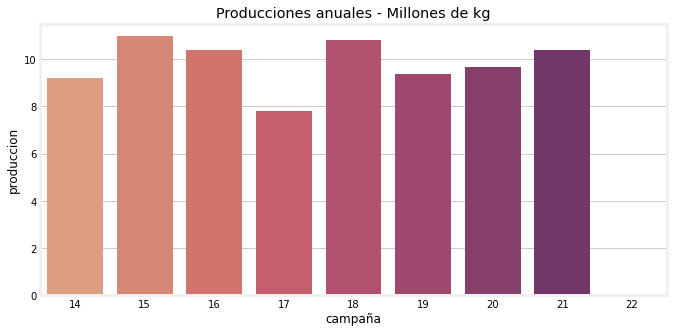

In [12]:
prod_anual = df.groupby('campaña')['produccion'].sum().reset_index()
prod_anual['produccion'] = prod_anual.produccion/1000000

plt.figure(facecolor="white", figsize=(10,5))
sns.barplot(data=prod_anual,x='campaña',y='produccion', palette= 'flare')
plt.title('Producciones anuales - Millones de kg')
plt.show()

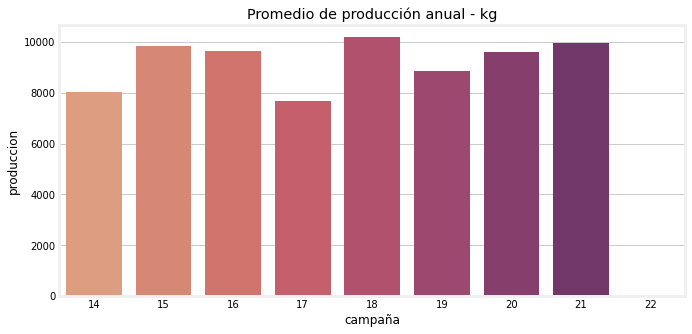

In [13]:
plt.figure(facecolor="white", figsize=(10,5))
sns.barplot(data=df.groupby('campaña')['produccion'].mean().reset_index(),x='campaña',y='produccion', palette= 'flare')
plt.title('Promedio de producción anual - kg')
plt.show()

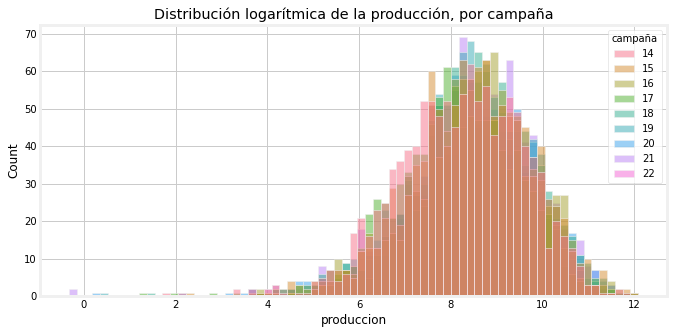

In [15]:
plt.figure(figsize=(10,5))
sns.histplot(
    df.assign(
        produccion = lambda df: np.log(df['produccion']),
        campaña = lambda df: df['campaña'].astype(str)
    ), 
    x='produccion', 
    hue='campaña'
)

plt.title('Distribución logarítmica de la producción, por campaña')
plt.show()

Box-plots

- Contamos con valores atípicos a simple vista, para producción y superficie

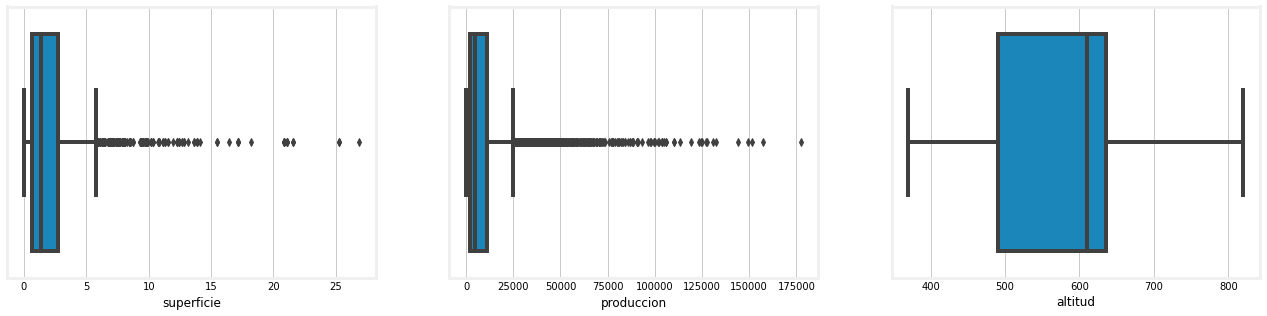

In [16]:
cont_vars = ['superficie', 'produccion', 'altitud']
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.boxplot(x=df[df['superficie']>0]['superficie'], ax=axes[0])
sns.boxplot(x=df['produccion'], ax=axes[1])
sns.boxplot(x=df['altitud'], ax=axes[2])
plt.show()

Relaciones entre variables continuas

- Aunque Train tenga la totalidad de sus columnas númericas, solo tomamos aquella cuya naturaleza tambien lo es
- Correlación fuerte entre superficie y produccion

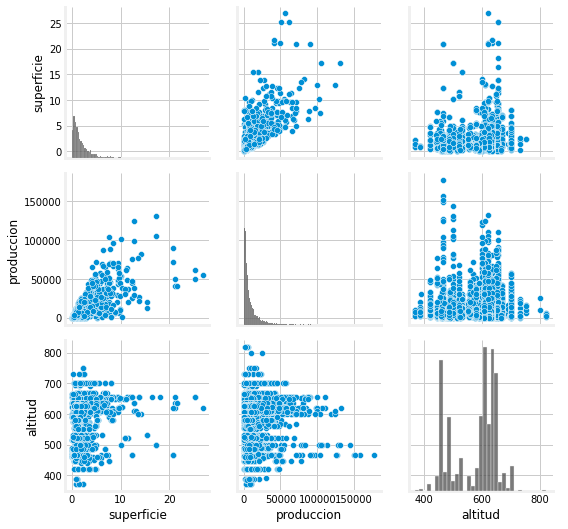

In [17]:
g = sns.PairGrid(df[cont_vars])
g.map_diag(sns.histplot, hue=None, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

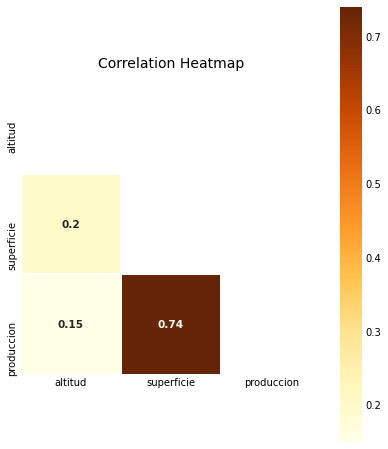

In [18]:
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(6,8))
    ax.set_facecolor('white')
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)

    plt.show()
    

var_corr = round(df[['altitud','superficie','produccion']].corr(),2)
Generate_heatmap_graph(var_corr
                       ,chart_title = 'Correlation Heatmap'
                       ,mask_uppertri = True)

Producción y superficie según variables binarias

- Vemos que el tipo 0 tiene picos mas altos que el 1 para produccion
- El color 0, picos mas bajos que el 1 tanto para produccion como superficie

In [19]:
def plot_by(col):
    fig, axes = plt.subplots(1, 3, figsize=(10,7), sharey=True)
    fig.suptitle(f'{col.capitalize()} según tipo, color y modo')

    sns.violinplot(data=df, x='tipo', y=col, ax=axes[0], palette='Blues_r')
    sns.violinplot(data=df, x='color', y=col, ax=axes[1], palette='Blues_r')
    sns.violinplot(data=df, x='modo', y=col, ax=axes[2], palette='Blues_r')
    plt.show()

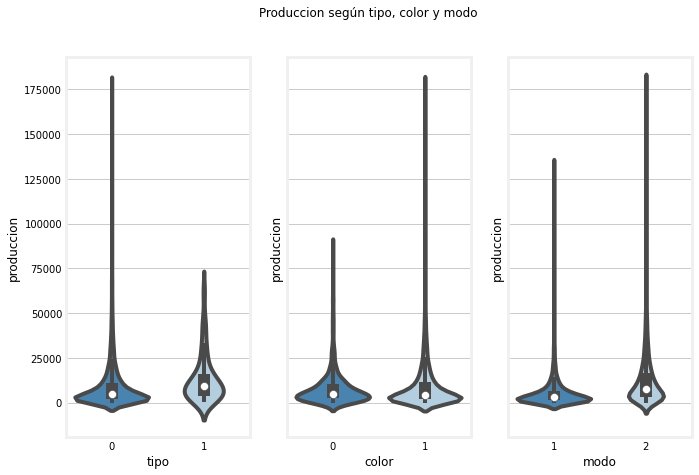

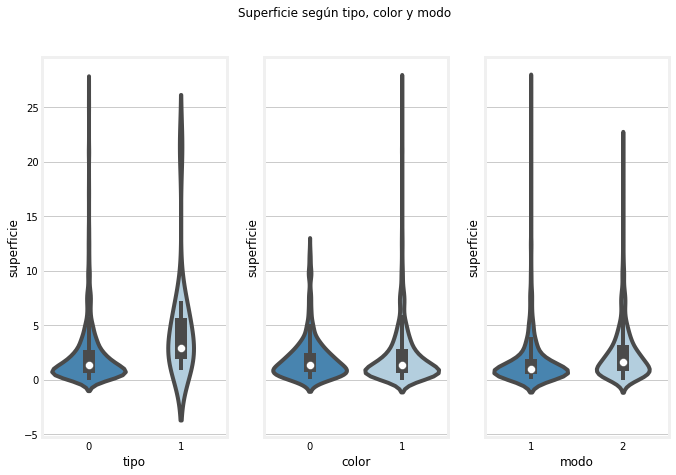

In [20]:
plot_by('produccion')
plot_by('superficie')

Producciones y superficies según ids

- Variedades

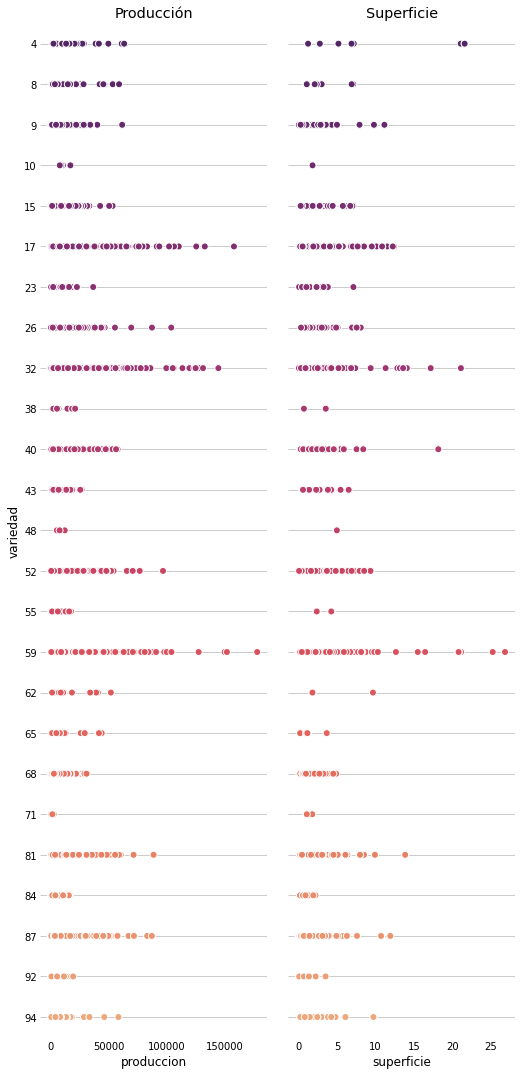

In [21]:
g = sns.PairGrid(df,
                 x_vars=['produccion','superficie'], y_vars=["variedad"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Producción", "Superficie"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

- Estacion

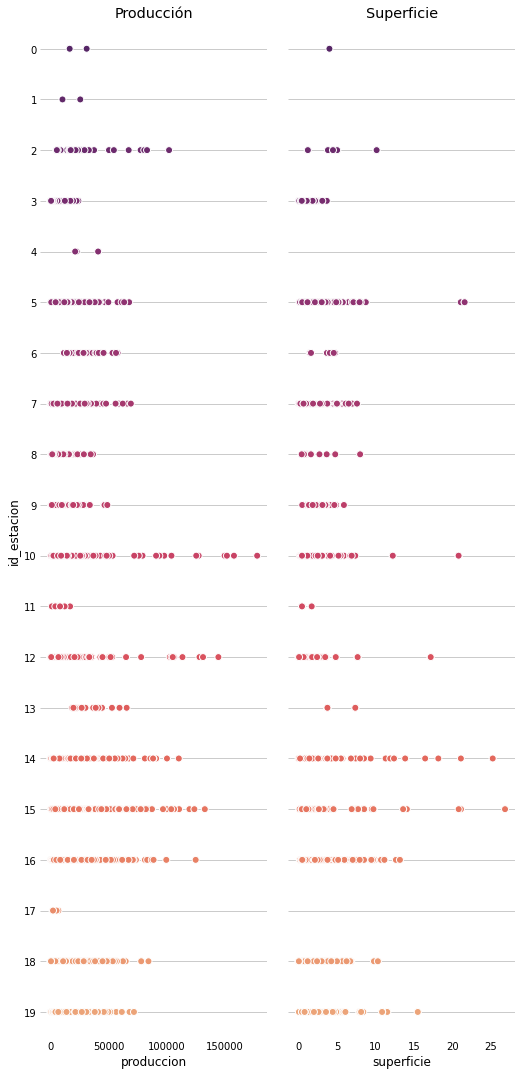

In [22]:
g = sns.PairGrid(df,
                 x_vars=['produccion','superficie'], y_vars=["id_estacion"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Producción", "Superficie"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Por último, observamos que hay fincas nuevas en cada campaña

In [83]:
df_check = df.copy()

df_check['concat'] = df_check.id_finca.astype(str) +  '-' +df_check.variedad.astype(str) +  '-'+ df_check.modo.astype(str) +  '-' +df_check.tipo.astype(str)

for year in [19,20,21,22]:
    df_year = df_check[df_check.campaña==year]
    df_lower = df_check[df_check.campaña<year]
    codigos = list(df_lower.concat.unique())
    df_year['exists'] = [1 if x in codigos else 0 for x in df_year.concat]
    nuevos_perc = (df_year.exists.value_counts()[0]/df_year.exists.count())*100
    print(f'Año {year} tiene {round(nuevos_perc,1)}% de fincas nuevas, teniendo en cuenta su variedad, modo y tipo')

Año 19 tiene 7.5% de fincas nuevas, teniendo en cuenta su variedad, modo y tipo
Año 20 tiene 10.3% de fincas nuevas, teniendo en cuenta su variedad, modo y tipo
Año 21 tiene 6.1% de fincas nuevas, teniendo en cuenta su variedad, modo y tipo
Año 22 tiene 8.0% de fincas nuevas, teniendo en cuenta su variedad, modo y tipo


## Outliers

Aunque un simple box-plot nos da a entender que hay valores extremos, preferimos probar si su eliminación pretende un mejor puntaje directamente en la modelización. Es por eso que se trataron de dos formas:

- Utilizando *IsolationForest* de sklearn.
- Utilizando la función generada *tukey_outliers*, cual tiene en cuenta quantiles para calcular valores extremos y luego eliminarlos.

Sin embargo, ningun modelo obtuvo un mejor puntaje al quitar outliers, por lo que no fue considerado este punto en el modelo final.

Debajo se deja en comentarios como se crearon los sets de entremanientos con estas dos funciones mencionadas.

IsolationForest

    from sklearn.ensemble import IsolationForest

    iso = IsolationForest(contamination=0.1)
    yhat = iso.fit_predict(X_train)
    mask = yhat != -1

    X_train['mask'] = mask
    X_train = X_train[X_train['mask']]
    y_train = y_train[mask]

    X_train.drop(columns=['mask'],inplace=True)

    print(X_train.shape, y_train.shape)

Tukey outliers
 
    def tukey_outliers(df,column,extreme=False):
        q1, q3 = np.percentile(df[column],[25,75])
        iqr = q3 - q1
        constant = 1.5 if not extreme else 3
        return df[~((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]

    for columna in ['superficie']:
        sin_outliers = tukey_outliers(X_train,columna,extreme=False)
        X_train=sin_outliers
        
    y_train = y_train[X_train.index]

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Análisis sobre variación de producción y superficies anuales

Estudiamos las variaciones de la produccion de año a año.

Para eso:

- Creamos funcion para obtener el valor del año anterior de la columna deseada.
- Creamos funcion para obtener la diferencia entre el valor actual y el pasado de la columna deseada, una vez ejecutada la funcion anterior.
- Aplicamos a una copia del dataframe original y visualizamos aquellos cambios más bruscos
- Visualizamos

In [23]:
def crear_shift(df,col):
    df = df.copy()
    df[f'{col}_t-1'] = df.groupby(['id_finca','variedad','modo'])[col].shift()
    df[f'{col}_t-2'] = df.groupby(['id_finca','variedad','modo'])[f'{col}_t-1'].shift()
    return df

In [24]:
def crear_diferencias(df,col):
    df = df.copy()
    df[f'dif_{col}'] = abs(df[f'{col}_t-1']-df[col])
    return df

In [25]:
df_shift = df.copy()
df_shift = crear_shift(df_shift,'produccion')
df_shift = crear_shift(df_shift,'superficie')
df_shift = crear_diferencias(df_shift,'produccion')
df_shift = crear_diferencias(df_shift,'superficie')
df_shift = df_shift.dropna(subset=['dif_produccion','dif_superficie'])

In [26]:
df_shift.sort_values('dif_produccion',ascending=False).head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,produccion_t-1,produccion_t-2,superficie_t-1,superficie_t-2,dif_produccion,dif_superficie
7567,21,37826,964,2,500.00,17,2,0,1,10.15,101750.00,54260.00,82800.00,10.15,NaN,47490.00,0.00
7684,21,14843,845,16,647.50,62,2,0,0,9.67,51708.18,6862.40,18236.83,9.67,NaN,44845.78,0.00
8409,21,93922,50,19,567.50,87,2,0,0,4.92,71550.00,29700.00,49510.00,4.92,NaN,41850.00,0.00
7976,21,10376,513,18,622.50,59,2,0,1,10.31,38093.10,1351.23,33570.97,10.31,NaN,36741.87,0.00
8049,21,76459,510,15,600.00,26,2,0,1,7.54,69200.00,103610.00,44520.00,7.54,NaN,34410.00,0.00


In [27]:
df_shift.sort_values('dif_superficie',ascending=False).head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,produccion_t-1,produccion_t-2,superficie_t-1,superficie_t-2,dif_produccion,dif_superficie
7596,21,3091,379,16,620.00,81,1,0,1,3.92,21433.20,11225.35,28248.56,9.93,NaN,10207.85,6.01
8067,21,95678,144,15,620.00,59,1,0,1,26.85,55520.00,41630.00,80810.00,21.12,NaN,13890.00,5.73
7673,21,797,845,16,647.50,59,1,0,1,7.51,11710.00,6950.00,29040.00,3.36,NaN,4760.00,4.16
8072,21,85984,144,15,620.00,59,2,0,1,8.28,32086.14,19279.98,18456.12,4.38,NaN,12806.16,3.90
8501,21,69003,349,19,455.00,59,1,0,1,5.88,26710.00,12250.00,25190.00,2.46,NaN,14460.00,3.41


Notamos que no hay una relación directa entre cambios en la producción y cambios en la superficie año a año, sino que una finca puede duplicar su producción sin haber cambiado su superficie.

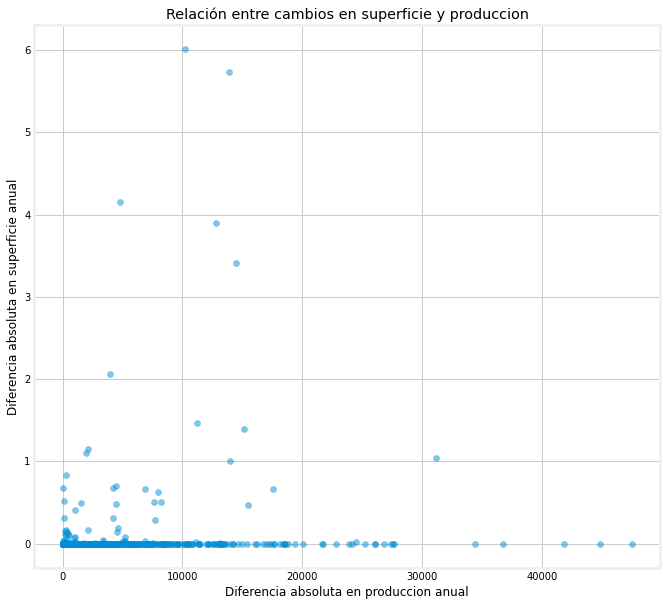

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(x=df_shift.dif_produccion, y=df_shift.dif_superficie , alpha=0.5)
plt.xlabel('Diferencia absoluta en produccion anual')
plt.ylabel('Diferencia absoluta en superficie anual')
plt.title('Relación entre cambios en superficie y produccion')
plt.show()

## Imputacion de datos faltantes

Contamos con NAs en:

- altitud
- superficie
- produccion

Los NA en produccion son los que hay que predecir, por lo que no serán imputados

In [29]:
df.isna().sum()

campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie     6518
produccion     1075
dtype: int64

Para altitud, reemplazamos por la media de la estacion, ya que una estacion tiene una sola altura y la relacion suele ser 1 a 1 con las fincas

In [30]:
df['altitud'] = df.groupby('id_estacion')['altitud'].transform(lambda x: x.fillna(x.mean()))

Para superficie, recordar que previamente reemplazamos los valores 0 por NAs, ya que asi venian los que no tenian datos. 

Para imputarlos, iremos calculando la media por mayor a menor desagregacion de los ids, hasta que no quede ninguno.

In [31]:
df['superficie'] = df.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_estacion','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad'])['superficie'].transform(lambda x: x.fillna(x.mean()))

df.superficie.isna().sum()

0

## Feature engineering

Creamos funciones para generar variables nuevas, siempre atentos a no realizar data leakage

- df_for_fe: dataframe para feature engineering, sin el año 21
- above_mean_col: variable que indique si para X valor de si una columna, la produccion fue mayor o menor a la media
- quantiles_col: parecida a la anterior, que indique si el id de la finca u otro id tiene una produccion en X quantil.

In [32]:
def df_for_fe(data):
    transf = data[data.campaña != 21]
    return transf

def above_mean_col(data,col):
    df = df_for_fe(data)
    above_mean = pd.DataFrame(df.groupby(col)['produccion'].mean() > df.produccion.mean())
    above_mean = list(above_mean[above_mean['produccion']].index)
    data[f'{col}_above_mean'] = [1 if x in above_mean else 0 for x in data[col]]
    return data

def quantiles_col(data,col):
    df = df_for_fe(data)
    quantiles_df = pd.DataFrame(df.groupby(col)['produccion'].mean()).reset_index()
    Q1 = quantiles_df.produccion.quantile(0.25)
    Q2 = quantiles_df.produccion.quantile(0.5)
    Q3 = quantiles_df.produccion.quantile(0.75)
    
    quantiles_df[f'{col}_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in quantiles_df.produccion]

    data = data.merge(quantiles_df[[col,f'{col}_percentiles']], how='left', on = col) #Joineamos con el df transformado
    
    return data

Aplicamos above_mean_col para altitud y variedad, y quantiles_col a finca y zona

In [33]:
for col in ['altitud','variedad']:
    df=above_mean_col(df,col)
    
for col in ['id_finca','id_zona']:
    df=quantiles_col(df,col)

El resultado de esto se ve en las ultimas 4 columnas del dataframe actualizado:

In [34]:
df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,altitud_above_mean,variedad_above_mean,id_finca_percentiles,id_zona_percentiles
0,14,76953,515,4,660.00,26,2,0,1,2.64,22215.00,0,1,3.00,3
1,14,84318,515,4,660.00,26,2,0,1,2.64,22215.00,0,1,3.00,3
2,14,85579,340,4,520.00,32,2,0,1,2.91,20978.00,1,1,3.00,3
3,14,69671,340,4,520.00,32,2,0,1,2.91,40722.00,1,1,3.00,3
4,14,14001,852,14,659.10,81,1,0,1,2.82,14126.00,1,0,3.00,1


Reemplazamos los pocos valores faltantes que resultan de la funcion quantiles_col

In [35]:
df['id_finca_percentiles'] = df.id_finca_percentiles.fillna(df_for_fe(df).id_finca_percentiles.mean())

# Meteo

# ETO

Contiene información agregada y transformada de las estaciones climatológicas de The Weather Company en el mismo periodo, las variables se construyen con el siguiente patrón (excepto las variables date y ID_Estacion):

Variable + “Local” + periodo + tipo de agregación

<center><img src="https://www.cajamardatalab.com/datathon-cajamar-universityhack-2023/reto-lavina/periodos.png" /></center>


Cargamos datos

In [36]:
df_eto = pd.read_csv(path +'/DATOS_ETO.txt', sep= '|', header=0 )

Primera visualización

In [37]:
df_eto.head()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,DewpointLocalEveningAvg,DewpointLocalEveningMax,DewpointLocalEveningMin,DewpointLocalMorningAvg,DewpointLocalMorningMax,DewpointLocalMorningMin,DewpointLocalNighttimeAvg,DewpointLocalNighttimeMax,DewpointLocalNighttimeMin,DewpointLocalOvernightAvg,DewpointLocalOvernightMax,DewpointLocalOvernightMin,EvapotranspirationLocalAfternoonAvg,EvapotranspirationLocalAfternoonMax,EvapotranspirationLocalAfternoonMin,EvapotranspirationLocalDayAvg,EvapotranspirationLocalDayMax,EvapotranspirationLocalDayMin,EvapotranspirationLocalDaytimeAvg,EvapotranspirationLocalDaytimeMax,EvapotranspirationLocalDaytimeMin,EvapotranspirationLocalEveningAvg,EvapotranspirationLocalEveningMax,EvapotranspirationLocalEveningMin,EvapotranspirationLocalMorningAvg,EvapotranspirationLocalMorningMax,EvapotranspirationLocalMorningMin,EvapotranspirationLocalNighttimeAvg,EvapotranspirationLocalNighttimeMax,EvapotranspirationLocalNighttimeMin,EvapotranspirationLocalOvernightAvg,EvapotranspirationLocalOvernightMax,EvapotranspirationLocalOvernightMin,FeelsLikeLocalAfternoonAvg,FeelsLikeLocalAfternoonMax,FeelsLikeLocalAfternoonMin,FeelsLikeLocalDayAvg,FeelsLikeLocalDayMax,FeelsLikeLocalDayMin,FeelsLikeLocalDaytimeAvg,FeelsLikeLocalDaytimeMax,FeelsLikeLocalDaytimeMin,FeelsLikeLocalEveningAvg,FeelsLikeLocalEveningMax,FeelsLikeLocalEveningMin,FeelsLikeLocalMorningAvg,FeelsLikeLocalMorningMax,FeelsLikeLocalMorningMin,FeelsLikeLocalNighttimeAvg,FeelsLikeLocalNighttimeMax,FeelsLikeLocalNighttimeMin,FeelsLikeLocalOvernightAvg,FeelsLikeLocalOvernightMax,FeelsLikeLocalOvernightMin,GlobalHorizontalIrradianceLocalAfternoonAvg,GlobalHorizontalIrradianceLocalAfternoonMax,GlobalHorizontalIrradianceLocalAfternoonMin,GlobalHorizontalIrradianceLocalDayAvg,GlobalHorizontalIrradianceLocalDayMax,GlobalHorizontalIrradianceLocalDayMin,GlobalHorizontalIrradianceLocalDaytimeAvg,GlobalHorizontalIrradianceLocalDaytimeMax,GlobalHorizontalIrradianceLocalDaytimeMin,GlobalHorizontalIrradianceLocalEveningAvg,GlobalHorizontalIrradianceLocalEveningMax,GlobalHorizontalIrradianceLocalEveningMin,GlobalHorizontalIrradianceLocalMorningAvg,GlobalHorizontalIrradianceLocalMorningMax,GlobalHorizontalIrradianceLocalMorningMin,GlobalHorizontalIrradianceLocalNighttimeAvg,GlobalHorizontalIrradianceLocalNighttimeMax,GlobalHorizontalIrradianceLocalNighttimeMin,GlobalHorizontalIrradianceLocalOvernightAvg,GlobalHorizontalIrradianceLocalOvernightMax,GlobalHorizontalIrradianceLocalOvernightMin,GustLocalAfternoonAvg,GustLocalAfternoonMax,GustLocalAfternoonMin,GustLocalDayAvg,GustLocalDayMax,GustLocalDayMin,GustLocalDaytimeAvg,GustLocalDaytimeMax,GustLocalDaytimeMin,GustLocalEveningAvg,GustLocalEveningMax,GustLocalEveningMin,GustLocalMorningAvg,GustLocalMorningMax,GustLocalMorningMin,GustLocalNighttimeAvg,GustLocalNighttimeMax,GustLocalNighttimeMin,GustLocalOvernightAvg,GustLocalOvernightMax,GustLocalOvernightMin,MSLPLocalAfternoonAvg,MSLPLocalAfternoonMax,MSLPLocalAfternoonMin,MSLPLocalDayAvg,MSLPLocalDayMax,MSLPLocalDayMin,MSLPLocalDaytimeAvg,MSLPLocalDaytimeMax,MSLPLocalDaytimeMin,MSLPLocalEveningAvg,MSLPLocalEveningMax,MSLPLocalEveningMin,MSLPLocalMorningAvg,MSLPLocalMorningMax,MSLPLocalMorningMin,MSLPLocalNighttimeAvg,MSLPLocalNighttimeMax,MSLPLocalNighttimeMin,MSLPLocalOvernightAvg,MSLPLocalOvernightMax,MSLPLocalOvernightMin,PrecipAmountLocalAfternoonAvg,PrecipAmountLocalAfternoonMax,PrecipAmountLocalAfternoonMin,PrecipAmountLocalDayAvg,PrecipAmountLocalDayMax,PrecipAmountLocalDayMin,PrecipAmountLocalDaytimeAvg,PrecipAmountLocalDaytimeMax,PrecipAmountLocalDaytimeMin,PrecipAmountLocalEveningAvg,PrecipAmountLocalEveningMax,PrecipAmountLocalEveningMin,PrecipAmountLocalMorningAvg,PrecipAmountLocalMorningMax,PrecipAmountLocalMorningMin,PrecipAmountLocalNighttimeAvg,PrecipAmountLocalNighttimeMax,PrecipAmountLocalNi

Ajustamos nombres de columnas bajo buenas prácticas

In [38]:
print(f'Número de filas: {df_eto.shape[0]}, Número de columnas:{df_eto.shape[1]}')
print(f'\nCantidad de duplicados: {df_eto.duplicated().sum()}\n')
print('-'*30 + 'Tipos de columnas'+ '-'*30)
print(df_eto.dtypes)
print('-'*30 + 'Cantidad de nulos totales' +'-'*30)
df_eto.isna().sum().sum()

Número de filas: 51180, Número de columnas:275

Cantidad de duplicados: 0

------------------------------Tipos de columnas------------------------------
date                            int64
DewpointLocalAfternoonAvg     float64
DewpointLocalAfternoonMax     float64
DewpointLocalAfternoonMin     float64
DewpointLocalDayAvg           float64
                               ...   
WindSpeedLocalNighttimeMin    float64
WindSpeedLocalOvernightAvg    float64
WindSpeedLocalOvernightMax    float64
WindSpeedLocalOvernightMin    float64
ID_ESTACION                     int64
Length: 275, dtype: object
------------------------------Cantidad de nulos totales------------------------------


2633460

### Nulos

Hay cuatro columnas con grandes cantidades de nulos:

- Gust: más que 40K
- GlobalHorizontalIrradiance: más que 30K
- Evapotranspiration: más que 30K
- MSLP: más que 15K

In [39]:
nulos = pd.DataFrame(df_eto.isna().sum(),columns=['nulls'])
nulos[nulos.nulls>0].sort_values('nulls',ascending=False)
nulos.sort_values('nulls',ascending=False).T

,GustLocalOvernightMin,GustLocalOvernightMax,GustLocalOvernightAvg,GustLocalMorningMin,GustLocalMorningMax,GustLocalMorningAvg,GustLocalEveningMin,GustLocalEveningMax,GustLocalEveningAvg,GustLocalNighttimeMin,GustLocalNighttimeMax,GustLocalNighttimeAvg,GustLocalAfternoonMin,GustLocalAfternoonMax,GustLocalAfternoonAvg,GustLocalDaytimeMin,GustLocalDaytimeAvg,GustLocalDaytimeMax,GustLocalDayMin,GustLocalDayAvg,GustLocalDayMax,GlobalHorizontalIrradianceLocalMorningAvg,GlobalHorizontalIrradianceLocalEveningMin,EvapotranspirationLocalMorningMin,EvapotranspirationLocalMorningMax,EvapotranspirationLocalMorningAvg,EvapotranspirationLocalEveningMin,EvapotranspirationLocalEveningMax,EvapotranspirationLocalEveningAvg,GlobalHorizontalIrradianceLocalEveningMax,GlobalHorizontalIrradianceLocalMorningMax,GlobalHorizontalIrradianceLocalMorningMin,GlobalHorizontalIrradianceLocalEveningAvg,GlobalHorizontalIrradianceLocalDaytimeAvg,GlobalHorizontalIrradianceLocalDayMin,GlobalHorizontalIrradianceLocalDayMax,GlobalHorizontalIrradianceLocalDayAvg,GlobalHorizontalIrradianceLocalAfternoonMin,GlobalHorizontalIrradianceLocalDaytimeMin,GlobalHorizontalIrradianceLocalOvernightMax,GlobalHorizontalIrradianceLocalNighttimeAvg,GlobalHorizontalIrradianceLocalNighttimeMax,GlobalHorizontalIrradianceLocalNighttimeMin,GlobalHorizontalIrradianceLocalOvernightAvg,GlobalHorizontalIrradianceLocalAfternoonAvg,GlobalHorizontalIrradianceLocalOvernightMin,GlobalHorizontalIrradianceLocalAfternoonMax,GlobalHorizontalIrradianceLocalDaytimeMax,EvapotranspirationLocalAfternoonAvg,EvapotranspirationLocalDaytimeAvg,EvapotranspirationLocalOvernightAvg,EvapotranspirationLocalNighttimeMin,EvapotranspirationLocalNighttimeMax,EvapotranspirationLocalNighttimeAvg,EvapotranspirationLocalDaytimeMin,EvapotranspirationLocalDaytimeMax,EvapotranspirationLocalDayMin,EvapotranspirationLocalOvernightMin,EvapotranspirationLocalDayMax,EvapotranspirationLocalDayAvg,EvapotranspirationLocalAfternoonMin,EvapotranspirationLocalAfternoonMax,EvapotranspirationLocalOvernightMax,MSLPLocalMorningAvg,MSLPLocalMorningMax,MSLPLocalMorningMin,MSLPLocalAfternoonMax,MSLPLocalDayMax,MSLPLocalOvernightMax,MSLPLocalOvernightAvg,MSLPLocalNighttimeAvg,MSLPLocalNighttimeMin,MSLPLocalNighttimeMax,MSLPLocalAfternoonAvg,MSLPLocalAfternoonMin,MSLPLocalDayAvg,MSLPLocalOvernightMin,MSLPLocalDayMin,MSLPLocalDaytimeMax,MSLPLocalDaytimeMin,MSLPLocalEveningAvg,MSLPLocalEveningMax,MSLPLocalEveningMin,MSLPLocalDaytimeAvg,WindSpeedLocalMorningMin,PrecipAmountLocalMorningMax,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,SnowAmountLocalMorningMin,PrecipAmountLocalMorningAvg,SnowAmountLocalMorningAvg,SnowAmountLocalMorningMax,DewpointLocalMorningAvg,TemperatureLocalMorningAvg,PrecipAmountLocalMorningMin,FeelsLikeLocalMorningMax,UVIndexLocalMorningMax,RelativeHumidityLocalMorningMax,VisibilityLocalMorningAvg,FeelsLikeLocalMorningMin,DewpointLocalMorningMax,FeelsLikeLocalMorningAvg,VisibilityLocalMorningMax,VisibilityLocalMorningMin,RelativeHumidityLocalMorningMin,UVIndexLocalMorningAvg,UVIndexLocalMorningMin,TemperatureLocalMorningMin,TemperatureLocalMorningMax,DewpointLocalMorningMin,RelativeHumidityLocalMorningAvg,UVIndexLocalEveningMin,UVIndexLocalEveningAvg,UVIndexLocalEveningMax,UVIndexLocalDaytimeMin,UVIndexLocalDaytimeMax,UVIndexLocalDaytimeAvg,UVIndexLocalDayMin,UVIndexLocalDayMax,UVIndexLocalDayAvg,UVIndexLocalAfternoonMin,TemperatureLocalNighttimeAvg,SnowAmountLocalOvernightMin,TemperatureLocalAfternoonAvg,TemperatureLocalNighttimeMin,TemperatureLocalOvernightAvg,TemperatureLocalOvernightMax,TemperatureLocalOvernightMin,UVIndexLocalAfternoonAvg,TemperatureLocalEveningMin,TemperatureLocalEveningMax,TemperatureLocalEveningAvg,TemperatureLocalDaytimeMin,TemperatureLocalDaytimeMax,TemperatureLocalDaytimeAvg,TemperatureLocalDayMin,TemperatureLocalDayMax,UVIndexLocalAfternoonMax,TemperatureLocalNighttimeMax,TemperatureLocalAfternoonMin,TemperatureLocalAfternoonMax,TemperatureLocalDayAvg,date,UVIndexLocalNighttimeAvg,UVIndexLoca

### Feature engineering

Dado que la fecha viene como integer, la convertimos a datetime

In [40]:
df_eto[['date']] = df_eto[['date']].applymap(str).applymap(lambda x: "{}/{}/{}".format(x[4:6],x[6:], x[0:4]))
df_eto['date'] = pd.to_datetime(df_eto.date)

Aprovechamos la manipulación para crear features de tipo fecha

In [41]:
df_eto['mes']= df_eto.date.dt.month_name()
df_eto['mes_num']= df_eto.date.dt.month
df_eto['año']= df_eto.date.dt.year.astype("int32")

De las variables de lluvia y nieve podemos obtener el total a partir del promedio, multiplicando por la cantidad de horas necesaria

In [42]:
df_eto['lluvia_amount'] = df_eto['PrecipAmountLocalDayAvg'] *24
df_eto['nieve_amount']  = df_eto['SnowAmountLocalDayAvg']   *24

### Agrupacion

Para que nos sirva este dataset a la hora de realizar modelos, necesitaremos joinearlo con el dataframe Train. 

Dado que Train viene por campaña (año) y este por día, necesitaremos escoger una agrupación, ya que sino deberiamos agregar una columna para cada dia de cada año.

El join será creado por Año=campaña, id_estacion=id_estacion.

La agrupación final se plasma en un dataframe llamado df_mensual, ya que este es el último grado de agrupación. Para las todas las variables salvo lluvia y nieve, se utilizo la media. Para las mencionadas, la suma.

In [43]:
cols_mean = df_eto.columns[1:-8]
group_mean = df_eto.groupby(['ID_ESTACION','año','mes_num'])[cols_mean].mean()

cols_sum= ['lluvia_amount', 'nieve_amount']
group_sum = df_eto.groupby(['ID_ESTACION','año','mes_num'])[cols_sum].sum()

df_mensual = pd.concat([group_mean,group_sum],axis=1).reset_index()

In [44]:
df_mensual.head()

,ID_ESTACION,año,mes_num,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,DewpointLocalEveningAvg,DewpointLocalEveningMax,DewpointLocalEveningMin,DewpointLocalMorningAvg,DewpointLocalMorningMax,DewpointLocalMorningMin,DewpointLocalNighttimeAvg,DewpointLocalNighttimeMax,DewpointLocalNighttimeMin,DewpointLocalOvernightAvg,DewpointLocalOvernightMax,DewpointLocalOvernightMin,EvapotranspirationLocalAfternoonAvg,EvapotranspirationLocalAfternoonMax,EvapotranspirationLocalAfternoonMin,EvapotranspirationLocalDayAvg,EvapotranspirationLocalDayMax,EvapotranspirationLocalDayMin,EvapotranspirationLocalDaytimeAvg,EvapotranspirationLocalDaytimeMax,EvapotranspirationLocalDaytimeMin,EvapotranspirationLocalEveningAvg,EvapotranspirationLocalEveningMax,EvapotranspirationLocalEveningMin,EvapotranspirationLocalMorningAvg,EvapotranspirationLocalMorningMax,EvapotranspirationLocalMorningMin,EvapotranspirationLocalNighttimeAvg,EvapotranspirationLocalNighttimeMax,EvapotranspirationLocalNighttimeMin,EvapotranspirationLocalOvernightAvg,EvapotranspirationLocalOvernightMax,EvapotranspirationLocalOvernightMin,FeelsLikeLocalAfternoonAvg,FeelsLikeLocalAfternoonMax,FeelsLikeLocalAfternoonMin,FeelsLikeLocalDayAvg,FeelsLikeLocalDayMax,FeelsLikeLocalDayMin,FeelsLikeLocalDaytimeAvg,FeelsLikeLocalDaytimeMax,FeelsLikeLocalDaytimeMin,FeelsLikeLocalEveningAvg,FeelsLikeLocalEveningMax,FeelsLikeLocalEveningMin,FeelsLikeLocalMorningAvg,FeelsLikeLocalMorningMax,FeelsLikeLocalMorningMin,FeelsLikeLocalNighttimeAvg,FeelsLikeLocalNighttimeMax,FeelsLikeLocalNighttimeMin,FeelsLikeLocalOvernightAvg,FeelsLikeLocalOvernightMax,FeelsLikeLocalOvernightMin,GlobalHorizontalIrradianceLocalAfternoonAvg,GlobalHorizontalIrradianceLocalAfternoonMax,GlobalHorizontalIrradianceLocalAfternoonMin,GlobalHorizontalIrradianceLocalDayAvg,GlobalHorizontalIrradianceLocalDayMax,GlobalHorizontalIrradianceLocalDayMin,GlobalHorizontalIrradianceLocalDaytimeAvg,GlobalHorizontalIrradianceLocalDaytimeMax,GlobalHorizontalIrradianceLocalDaytimeMin,GlobalHorizontalIrradianceLocalEveningAvg,GlobalHorizontalIrradianceLocalEveningMax,GlobalHorizontalIrradianceLocalEveningMin,GlobalHorizontalIrradianceLocalMorningAvg,GlobalHorizontalIrradianceLocalMorningMax,GlobalHorizontalIrradianceLocalMorningMin,GlobalHorizontalIrradianceLocalNighttimeAvg,GlobalHorizontalIrradianceLocalNighttimeMax,GlobalHorizontalIrradianceLocalNighttimeMin,GlobalHorizontalIrradianceLocalOvernightAvg,GlobalHorizontalIrradianceLocalOvernightMax,GlobalHorizontalIrradianceLocalOvernightMin,GustLocalAfternoonAvg,GustLocalAfternoonMax,GustLocalAfternoonMin,GustLocalDayAvg,GustLocalDayMax,GustLocalDayMin,GustLocalDaytimeAvg,GustLocalDaytimeMax,GustLocalDaytimeMin,GustLocalEveningAvg,GustLocalEveningMax,GustLocalEveningMin,GustLocalMorningAvg,GustLocalMorningMax,GustLocalMorningMin,GustLocalNighttimeAvg,GustLocalNighttimeMax,GustLocalNighttimeMin,GustLocalOvernightAvg,GustLocalOvernightMax,GustLocalOvernightMin,MSLPLocalAfternoonAvg,MSLPLocalAfternoonMax,MSLPLocalAfternoonMin,MSLPLocalDayAvg,MSLPLocalDayMax,MSLPLocalDayMin,MSLPLocalDaytimeAvg,MSLPLocalDaytimeMax,MSLPLocalDaytimeMin,MSLPLocalEveningAvg,MSLPLocalEveningMax,MSLPLocalEveningMin,MSLPLocalMorningAvg,MSLPLocalMorningMax,MSLPLocalMorningMin,MSLPLocalNighttimeAvg,MSLPLocalNighttimeMax,MSLPLocalNighttimeMin,MSLPLocalOvernightAvg,MSLPLocalOvernightMax,MSLPLocalOvernightMin,PrecipAmountLocalAfternoonAvg,PrecipAmountLocalAfternoonMax,PrecipAmountLocalAfternoonMin,PrecipAmountLocalDayAvg,PrecipAmountLocalDayMax,PrecipAmountLocalDayMin,PrecipAmountLocalDaytimeAvg,PrecipAmountLocalDaytimeMax,PrecipAmountLocalDaytimeMin,PrecipAmountLocalEveningAvg,PrecipAmountLocalEveningMax,PrecipAmountLocalEveningMin,PrecipAmountLocalMorningAvg,PrecipAmountLocalMorningMax,PrecipAmountLocalMorningMin,PrecipAmountLocalNighttimeAvg,PrecipAmountLocalNighttimeMax,

Notamos muchos NAs, algunos que causaran la no consideración de variables. Sin embargo, rescatamos los de MSLP y Gust imputandolos por la media por estación y mes.

Las columnas a eliminar ya sea por cantidad de nulos o por poca relevancia son temperaturas del día entero en vez de afternoon-overnight, precipitaciones y nieves que luego fueron agrupadas, Dewpoint, Evapotranspiration, Feelslike y globalhorizontalirradiance. 

Llamaremos a este nuevo dataframe: df_grouped

In [45]:
df_mensual['MSLPLocalDayAvg']  =df_mensual.groupby(['ID_ESTACION','mes_num'])['MSLPLocalDayAvg'].transform(lambda x: x.fillna(x.mean()))
df_mensual['GustLocalDayAvg']  =df_mensual.groupby(['ID_ESTACION','mes_num'])['GustLocalDayAvg'].transform(lambda x: x.fillna(x.mean()))


In [46]:
avg_cols_days = list(df_mensual.filter(like='DayAvg').columns)
ids = ['ID_ESTACION','año','mes_num']
temperaturas = ['TemperatureLocalAfternoonAvg','TemperatureLocalOvernightAvg']
df_grouped = df_mensual[ids + avg_cols_days + cols_sum + temperaturas]

cols_delete = ['TemperatureLocalDayAvg', 'PrecipAmountLocalDayAvg', 'SnowAmountLocalDayAvg','DewpointLocalDayAvg',
                'EvapotranspirationLocalDayAvg', 'FeelsLikeLocalDayAvg','GlobalHorizontalIrradianceLocalDayAvg']

df_grouped = df_grouped.drop(columns=cols_delete)

In [47]:
df_grouped.head()

,ID_ESTACION,año,mes_num,GustLocalDayAvg,MSLPLocalDayAvg,RelativeHumidityLocalDayAvg,UVIndexLocalDayAvg,VisibilityLocalDayAvg,WindSpeedLocalDayAvg,lluvia_amount,nieve_amount,TemperatureLocalAfternoonAvg,TemperatureLocalOvernightAvg
0,0,2015,6,5.90,101532.45,42.60,1.45,16093.00,3.35,0.00,0.00,308.00,292.50
1,0,2015,7,5.65,101491.24,61.76,2.46,16028.65,2.65,16.80,0.00,305.94,295.16
2,0,2015,8,6.68,101584.90,70.84,2.04,15826.06,2.73,156.00,0.00,302.61,293.87
3,0,2015,9,6.27,101804.92,75.87,1.46,15581.60,2.46,153.60,0.00,297.20,289.43
4,0,2015,10,5.58,101805.97,80.55,0.88,15730.13,2.21,74.40,0.00,293.55,287.19


Dado que solo podemos utilizar información del clima hasta el mes de junio, y que en los meses desde la cosecha el viñedo entra en un período de descanso, nos quedaremos con el rango de meses de Enero a Junio.

(Cabe notar que tambien se ha intentado modelizar con la totalidad de los meses, pero no hubo mejoras en los resultados de los modelos)

In [48]:
df_grouped=df_grouped[df_grouped['mes_num'].isin([1,2,3,4,5,6])]

In [49]:
df_grouped.isna().sum()

ID_ESTACION                     0
año                             0
mes_num                         0
GustLocalDayAvg                 0
MSLPLocalDayAvg                 0
RelativeHumidityLocalDayAvg     0
UVIndexLocalDayAvg              0
VisibilityLocalDayAvg           0
WindSpeedLocalDayAvg            0
lluvia_amount                   0
nieve_amount                    0
TemperatureLocalAfternoonAvg    0
TemperatureLocalOvernightAvg    0
dtype: int64

Visualizamos la correlación entre estas variables climáticas

Fuera de las correlaciones obvias como aquellas de temperaturas diurnas y nocturnas, vemos algunas como temperaturas con UVindex o temperatura y humedad que nos pueden servir en un futuro.

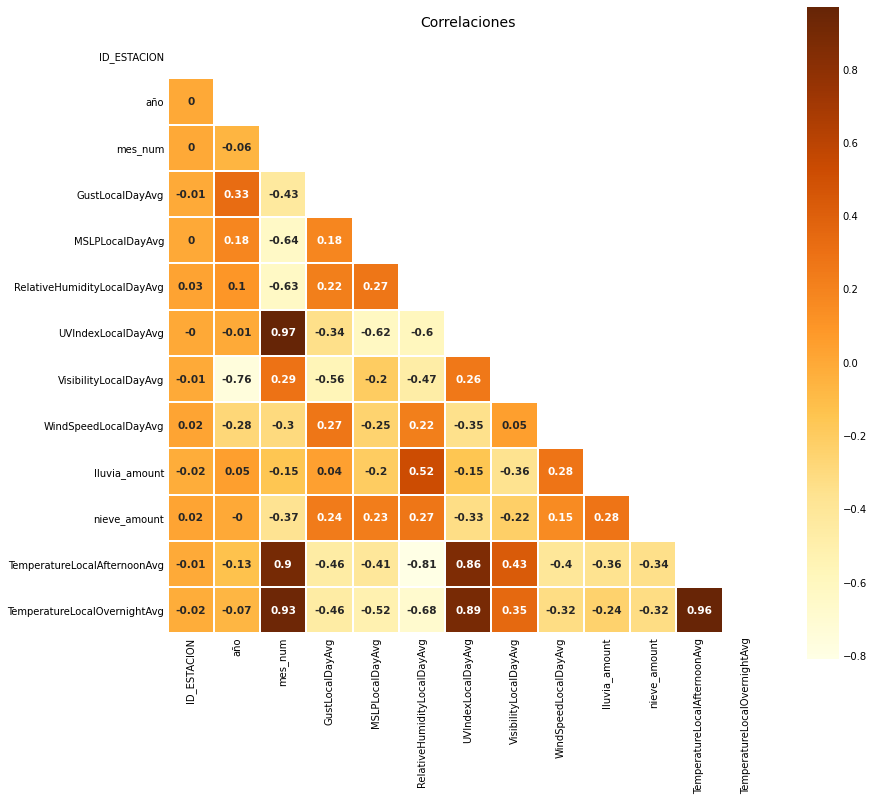

In [50]:
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(12,12))
    ax.set_facecolor('white')
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)

    plt.show()

num_cols =  df_grouped.select_dtypes([np.number]).columns

df_num = df_grouped[num_cols]

cor_mat = round(df_num.corr(),2)

Generate_heatmap_graph(cor_mat
                       ,chart_title = 'Correlaciones'
                       ,mask_uppertri = True)

Para poder pasar esta información al dataset Train, necesitamos pivotear el dataframe.

- Llamaremos a este nuevo dataframe: df_for_join
- Notar la presencia de nulos en los meses de enero a mayo en 2015, donde no hay datos del clima. Tambien habrán nulos en 2014 luego de cruzar los datos

De esta manera, obtenemos un set de datos nuevo con el nombre de la variable y su mes correspondiente, listo para ser cruzado al Train. Este, sin embargo, cuenta con 62 columnas, lo cual puede "sobrealimentar" al modelo.

In [61]:
values_cols = list(df_grouped.filter(like='DayAvg').columns) + cols_sum + temperaturas

df_for_join = df_grouped.pivot(index=['año','ID_ESTACION'], columns='mes_num', values=values_cols).reset_index()
df_for_join.columns = [x +'_'+ str(y) if y != '' else x for x,y in df_for_join.columns.to_flat_index()]
df_for_join.head(5)

,año,ID_ESTACION,GustLocalDayAvg_1,GustLocalDayAvg_2,GustLocalDayAvg_3,GustLocalDayAvg_4,GustLocalDayAvg_5,GustLocalDayAvg_6,MSLPLocalDayAvg_1,MSLPLocalDayAvg_2,MSLPLocalDayAvg_3,MSLPLocalDayAvg_4,MSLPLocalDayAvg_5,MSLPLocalDayAvg_6,RelativeHumidityLocalDayAvg_1,RelativeHumidityLocalDayAvg_2,RelativeHumidityLocalDayAvg_3,RelativeHumidityLocalDayAvg_4,RelativeHumidityLocalDayAvg_5,RelativeHumidityLocalDayAvg_6,UVIndexLocalDayAvg_1,UVIndexLocalDayAvg_2,UVIndexLocalDayAvg_3,UVIndexLocalDayAvg_4,UVIndexLocalDayAvg_5,UVIndexLocalDayAvg_6,VisibilityLocalDayAvg_1,VisibilityLocalDayAvg_2,VisibilityLocalDayAvg_3,VisibilityLocalDayAvg_4,VisibilityLocalDayAvg_5,VisibilityLocalDayAvg_6,WindSpeedLocalDayAvg_1,WindSpeedLocalDayAvg_2,WindSpeedLocalDayAvg_3,WindSpeedLocalDayAvg_4,WindSpeedLocalDayAvg_5,WindSpeedLocalDayAvg_6,lluvia_amount_1,lluvia_amount_2,lluvia_amount_3,lluvia_amount_4,lluvia_amount_5,lluvia_amount_6,nieve_amount_1,nieve_amount_2,nieve_amount_3,nieve_amount_4,nieve_amount_5,nieve_amount_6,TemperatureLocalAfternoonAvg_1,TemperatureLocalAfternoonAvg_2,TemperatureLocalAfternoonAvg_3,TemperatureLocalAfternoonAvg_4,TemperatureLocalAfternoonAvg_5,TemperatureLocalAfternoonAvg_6,TemperatureLocalOvernightAvg_1,TemperatureLocalOvernightAvg_2,TemperatureLocalOvernightAvg_3,TemperatureLocalOvernightAvg_4,TemperatureLocalOvernightAvg_5,TemperatureLocalOvernightAvg_6
0,2015,0,NaN,NaN,NaN,NaN,NaN,5.90,NaN,NaN,NaN,NaN,NaN,101532.45,NaN,NaN,NaN,NaN,NaN,42.60,NaN,NaN,NaN,NaN,NaN,1.45,NaN,NaN,NaN,NaN,NaN,16093.00,NaN,NaN,NaN,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,308.00,NaN,NaN,NaN,NaN,NaN,292.50
1,2015,1,NaN,NaN,NaN,NaN,NaN,6.25,NaN,NaN,NaN,NaN,NaN,101553.19,NaN,NaN,NaN,NaN,NaN,36.65,NaN,NaN,NaN,NaN,NaN,1.60,NaN,NaN,NaN,NaN,NaN,16093.00,NaN,NaN,NaN,NaN,NaN,3.85,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,307.50,NaN,NaN,NaN,NaN,NaN,293.50
2,2015,2,NaN,NaN,NaN,NaN,NaN,8.04,NaN,NaN,NaN,NaN,NaN,101532.84,NaN,NaN,NaN,NaN,NaN,41.05,NaN,NaN,NaN,NaN,NaN,1.50,NaN,NaN,NaN,NaN,NaN,16093.00,NaN,NaN,NaN,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,307.85,NaN,NaN,NaN,NaN,NaN,292.60
3,2015,3,NaN,NaN,NaN,NaN,NaN,6.30,NaN,NaN,NaN,NaN,NaN,101547.07,NaN,NaN,NaN,NaN,NaN,38.90,NaN,NaN,NaN,NaN,NaN,1.50,NaN,NaN,NaN,NaN,NaN,16093.00,NaN,NaN,NaN,NaN,NaN,3.65,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,308.00,NaN,NaN,NaN,NaN,NaN,293.00
4,2015,4,NaN,NaN,NaN,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN,101541.87,NaN,NaN,NaN,NaN,NaN,37.10,NaN,NaN,NaN,NaN,NaN,1.50,NaN,NaN,NaN,NaN,NaN,16093.00,NaN,NaN,NaN,NaN,NaN,3.85,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,308.00,NaN,NaN,NaN,NaN,NaN,292.55


In [62]:
df_for_join.shape

(160, 62)

Ya en los ultimos pasos, imputamos nulos para 2015 como mencionamos previamente. Lo haremos por el promedio mensual por estación.

In [63]:
for col in df_for_join.columns:
    df_for_join[col]  = df_for_join.groupby(['ID_ESTACION'])[col].transform(lambda x: x.fillna(x.mean()))

df_for_join.isna().sum().max()

0

Última preparación para el cruce, pasando a formato campaña como en Train

In [64]:
df_for_join['campaña'] = df_for_join['año']%2000

df_for_join.drop(columns=['año'], inplace=True)

Podemos ir un paso más allá y procesar directamente los calculos anuales, para evitar entregarle un número muy grande de columnas al modelo.

Para esto, generamos funciones que nos reemplacen las variables de clima originales por su suma o promedio.

In [65]:
def eto_dict_generator(df):
    temp_strings = ['Gust','MSLP','Humidity','UVIndex','Visibility','WindSpeed',
                    'lluvia','nieve','TemperatureLocalAfternoon','TemperatureLocalOvernight']
    dic_temp = {}
    for string in temp_strings:
        columns = [col for col in df.columns if string in col]
        dic_temp[string] = columns
    return dic_temp


def eto_annual_sum(df,cols_list):
    dictionary = eto_dict_generator(df)
    dictionary = {key: dictionary[key] for key in cols_list}
    for name, data in dictionary.items():
            df[name] = df[data].sum(axis=1)
            df = df.drop(columns=data)
    return df


def eto_annual_mean(df,cols_list):
    dictionary = eto_dict_generator(df)
    dictionary = {key: dictionary[key] for key in cols_list}
    for name, data in dictionary.items():
            df[name] = df[data].mean(axis=1)
            df = df.drop(columns=data)
    return df

Asignamos a que columna calcularle el promedio y a cual la suma

In [66]:
sum_cols = ['Gust','lluvia','nieve']
mean_cols = ['MSLP','Humidity','UVIndex','Visibility','WindSpeed','TemperatureLocalAfternoon','TemperatureLocalOvernight']

df_for_join = eto_annual_sum(df_for_join,sum_cols)
df_for_join = eto_annual_mean(df_for_join,mean_cols)
df_for_join.head()

,ID_ESTACION,campaña,Gust,lluvia,nieve,MSLP,Humidity,UVIndex,Visibility,WindSpeed,TemperatureLocalAfternoon,TemperatureLocalOvernight
0,0,15,48.05,323.66,0.04,101780.37,62.95,1.20,13242.72,2.82,292.38,283.78
1,1,15,50.53,287.66,0.11,101796.16,63.02,1.23,13087.99,3.67,291.13,282.15
2,2,15,50.81,235.20,0.01,101791.29,62.17,1.23,13459.83,2.98,293.15,283.30
3,3,15,49.95,268.80,0.09,101788.69,63.78,1.21,13123.01,3.47,291.89,282.98
4,4,15,49.72,254.40,0.04,101795.73,61.91,1.22,13287.81,3.64,292.26,282.74


Visualizamos si cambian los valores según la campaña:

- Al agrupar tantas veces, tiene sentido que no haya mucha diferencia año a año.
- Esto se puede notar en las temperaturas por ejemplo.
- Sin embargo, hay cambios en Gust, con valores bajos en 2016, la lluvia baja en 2021, y la visibilidad alta en 2016, por ejemplo

In [67]:
df_for_join.groupby('campaña')[sum_cols + mean_cols].mean().style.background_gradient(cmap='Blues')

,Gust,lluvia,nieve,MSLP,Humidity,UVIndex,Visibility,WindSpeed,TemperatureLocalAfternoon,TemperatureLocalOvernight
campaña,,,,,,,,,,
15,49.475891,272.502857,0.064457,101791.398704,63.434978,1.208606,13178.985681,3.291767,292.128259,282.841865
16,42.777086,217.680000,0.001200,101791.398704,67.578681,1.327829,15836.862138,3.362898,291.410426,282.821219
17,54.165272,359.280000,0.175200,101791.398704,65.956819,1.406876,12679.869146,3.240398,291.640454,282.598634
18,52.765644,377.160000,0.034800,101461.185458,65.460513,1.376119,13076.793144,3.680662,289.780831,281.853949
19,54.263298,225.720000,0.000000,101843.978336,60.730597,1.392069,12742.188687,2.970603,291.125350,281.111704
20,52.364273,313.680000,0.140400,101932.363064,69.032436,1.367286,11966.616018,2.771384,291.391369,283.147637
21,51.878477,206.760000,0.093600,101787.369274,67.671546,1.351851,11439.076810,3.131399,290.215491,282.937864
22,51.143651,344.760000,0.006000,101932.097388,64.211839,1.355432,11507.505017,2.836274,291.324280,282.622577


Guardamos el dataset preprocesado

In [112]:
df_for_join.to_csv("C:/Users/denis/OneDrive/Escritorio/Datathon/datathon-cajamar-malbecs/data/processed/eto_processed_entrega.csv")

# Estrategias y modelos descartados

La mayor dificultad encontrada fue el como aprovechar los datos del clima. Para este se han intentado muchas estrategias, como por ejemplo:

- Del dataset agrupado ETO, generar sumas o promedios por estación del año (verano, invierno, primavera y otoño). Luego, pasarlas al Train y evaluar su importancia en el modelo y resultados.
- Se ha probado utilizar máximos, mínimos, promedios, desvíos, medianas mensuales de las variables de temperatura.
- Del dataset METEO, se han obtenido las horas de luz en el día, para luego sumarlas al Train.


En cuanto a elección de modelos se probaron diversas opciones:

- Modelos sin considerar las variables de temperatura
- Modelos considerando Train y ETO
- Modelos considerando Train, ETO y algunas variables construidas por METEO
- Modelos dummy cuya predicción sea la media según agregaciones de id
- Predecir el logaritmo de la produccion en vez de la produccion en si
- Generar un modelo para la superficie a la hora de imputar los valores sin datos, y luego otro para la producción
- Generar un modelo para produccion x superficie en vez de producción
- Separar el dataset en tres según el tamaño de superficie (pequeño, medio, grande) para que entrene con fincas de sus caracteristicas, y luego juntarlos
- Partir en train y test ignorando las campañas

Luego, en cuanto a tipo de modelos, se han probado regresores como:

- XGBoostRegressor
- CatBoostRegressor
- LinearRegression
- RandomForestRegressor
- DecisionTreeRegressor
- Otros

Para el cross-validation, al tratarse de una cuasi-serie temporal o datos de panel, no puede hacerse un split random. Por este motivo, se fue probando un split temporal, considerando cada vez más años de entramiento, con el año del test siendo siempre mayor al mayor del train.

Por último, se han probado combinaciones de algoritmos bajo **Stacking**.

Sin embargo, el mejor resultado, teniendo en cuenta el RMSE tanto de train como de test, fue utilizando un Pipeline con un modelo de **RandomForestRegressor** y encoders especificos seleccionados a prueba y error. 
La partición se ha realizado de manera tal que se tomó a 2014-2020 como entrenamiento, y 2021 como testing. 
No se ha logrado mejorar el modelo utilizando variables climáticas. Esto es causado en general por la perdida de información a la hora de agregar las variables de ETO/METEO.
Las variables que más peso tienen en el modelo son las consideradas **shift**, cuales muestran la produccion de los años pasados para cada finca, variedad y modo.

En este apartado mostraremos solo algunos de estos ejemplos mencionados más arriba, y al modelo con mejor resultado lo presentaremos directamente en el envío de predicciones

Unimos el Train con el ETO

- Generamos df_shift con producciones pasadas
- Joineamos


In [70]:
#Nuevo DF

df_shift = df[df.campaña < 22].copy()

#Shifts
df_shift['prod_shift1'] = df_shift.groupby(['id_finca','variedad','modo'])['produccion'].shift()
df_shift['prod_shift2'] = df_shift.groupby(['id_finca','variedad','modo'])['prod_shift1'].shift()

#Fillna
df_shift['prod_shift1'] = df_shift['prod_shift1'].fillna(-1)
df_shift['prod_shift2'] = df_shift['prod_shift2'].fillna(-1)

#Variables finales a partir de estas
df_shift['var_prod_shift'] = [1 if x>y else 0 for x,y in zip(df_shift.prod_shift1, df_shift.prod_shift2)] 
df_shift['shifts_avg']=[(x+y)/2 if y!=-1 else x for x,y in zip(df_shift.prod_shift1,df_shift.prod_shift2)]
df_shift['shifts_max']=[x if x>y else y for x,y in zip(df_shift.prod_shift1,df_shift.prod_shift2)]

#Elinamos originales de shift
df_shift.drop(columns=['prod_shift1','prod_shift2'],inplace=True)

In [71]:
df_for_join.columns = [x.lower() for x in df_for_join.columns]

In [72]:
df_join = df_shift.merge(df_for_join, how='left', on=['id_estacion', 'campaña'])

Rellenamos NAs para 2014 a partir de la media por estacion

In [73]:
for col in df_join.columns:
    df_join[col]  = df_join.groupby(['id_estacion'])[col].transform(lambda x: x.fillna(x.mean()))
    df_join[col]  = df_join[col].transform(lambda x: x.fillna(x.mean()))

Particion

In [74]:
cat_cols = ['campaña',
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color"
]

target = 'produccion'

X = df_join.loc[:, df_join.columns != target]
# X=X.drop(columns=extra_weather)

y = df_join[target]

X[cat_cols] = X[cat_cols].astype("category")

X_train = X.iloc[:len(df_join[df_join['campaña']<21]),:]
X_test = X.iloc[len(df_join[df_join['campaña']<21]):,:]
y_train = y.iloc[:len(df_join[df_join['campaña']<21])]
y_test = y.iloc[len(df_join[df_join['campaña']<21]):]

Modelo simple sin cross-validation utilizando RandomForestRegressor

In [75]:
#Modelo
rf = RandomForestRegressor(random_state=99)

#Entrenamiento
rf.fit(X_train, y_train)

#Predicciones
prediction = rf.predict(X_test)

#Resultados
rmse_score(y_test, prediction)

5609.297739470621

Las importancias de las variables para el modelo dan una idea de que las variables climáticas no tienen un peso mayor de decisión.

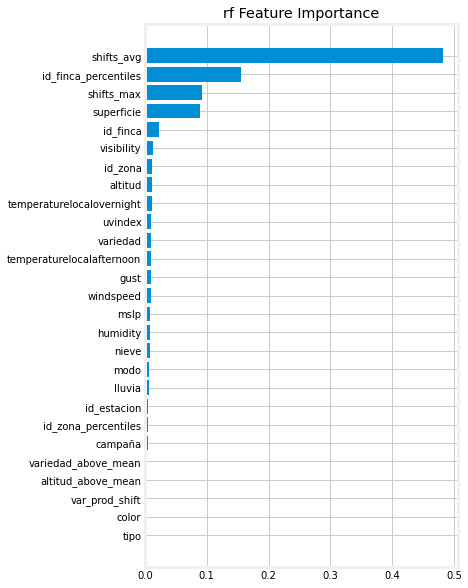

In [77]:
plt.figure(figsize=(5,10))

sorted_idx = rf.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=rf.feature_importances_[sorted_idx])
plt.title("rf Feature Importance")
plt.show()

Vemos que al modelo le cuesta estimar correctamente los valores altos de produccion

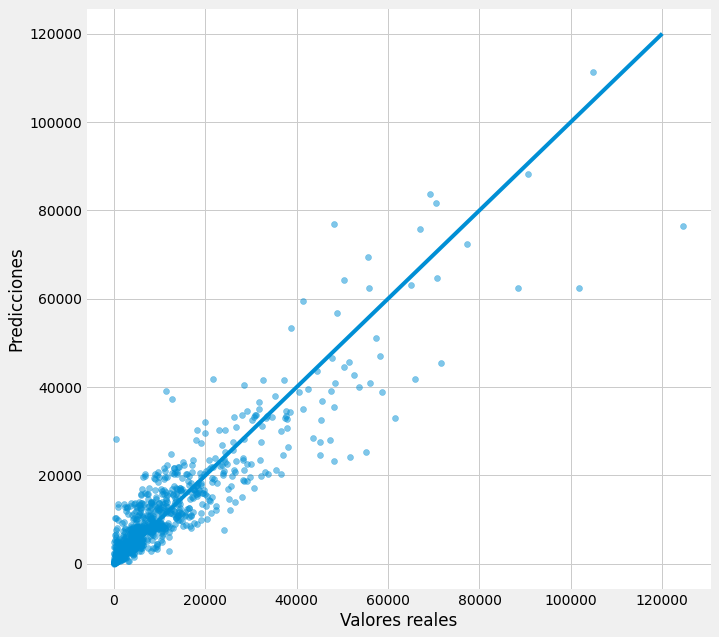

In [126]:
preds = pd.Series(prediction)
true = pd.Series(y_test.values)

plt.figure(figsize=(10,10))
plt.scatter(true, preds, alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()

Otro ejemplo de intento a mostrar es con las variables de METEO

Así mismo, se han probado librerias como TPOT, cual genera automáticamente el mejor modelo regresor.

Este, sin embargo, tiene un coste en terminos de tiempo, y el puntaje no fue lo suficientemente superador como para considerarlo.

Se deja el ejemplo en comentario:

        from tpot import TPOTRegressor

        tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=99)

        tpot.fit(X_train, y_train)

        preds = tpot.predict(X_test)

        rmse_score(y_test,preds) #5466.44

Tambien compartimos un ejemplo de cross-validation manual para la base de datos particular:

Este método fue utilizado tambien para probar distintos modelos y entender las tendencias naturales del dataset.

In [82]:
model = RandomForestRegressor(random_state=99)

for i in [18,19,20]:
    X_train = df_join.loc[df_join['campaña'] <= i, X.columns]
    Y_train = df_join.loc[df_join['campaña'] <= i, 'produccion']
    X_test =  df_join.loc[df_join['campaña'] > i, X.columns]
    Y_test =  df_join.loc[df_join['campaña'] > i, 'produccion']

    # Fit the train data.    
    model.fit(X_train, Y_train)

    # Test the model with test data.        
    y_pred = model.predict(X_test)

    # Save the mse.
    mse = mean_squared_error(Y_test, y_pred)
    print(i+1,np.sqrt(mse))

19 7024.644996681801
20 6897.9006233861655
21 5609.297739470621


Como paso final del análisis, se realizó una exploración de los errores cometidos por los modelos.

Este paso nos ayudo a ver la distribución de los errores, ya sea por si sola o por alguna variable predictora.

También nos ayudó a entender si el modelo estaba generando predicciones por encima o por debajo de los valores originales.

Generamos una copia de X_test y comparamos las predicciones con los valores originales:

In [84]:
comp = X_test.copy()
comp['produccion'] = y_test
comp['preds'] = prediction
comp['error'] = comp.produccion - comp.preds
comp['error_abs'] = abs(comp.error)

Visualizamos los errores mas altos

In [88]:
comp.sort_values(by='error_abs',ascending=False).head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,altitud_above_mean,variedad_above_mean,id_finca_percentiles,id_zona_percentiles,var_prod_shift,shifts_avg,shifts_max,gust,lluvia,nieve,mslp,humidity,uvindex,visibility,windspeed,temperaturelocalafternoon,temperaturelocalovernight,produccion,preds,error,error_abs
7646,21,48877,506,16,610.00,32,2,0,1,12.85,1,1,3.00,3,1,81027.63,99360.10,50.86,189.60,0.12,101786.21,67.68,1.35,11408.05,3.00,290.11,282.79,124620.26,76365.01,48255.25,48255.25
7567,21,37826,964,2,500.00,17,2,0,1,10.15,1,0,3.00,3,0,68530.00,82800.00,51.41,189.60,0.00,101781.34,66.15,1.37,11803.81,2.69,291.54,283.48,101750.00,62501.01,39248.99,39248.99
7524,21,86582,464,14,655.00,17,1,0,1,3.81,1,0,3.00,2,1,25275.25,31394.00,53.47,184.80,0.17,101789.53,68.23,1.35,11316.17,3.39,289.08,281.89,55077.00,25238.56,29838.44,29838.44
8513,21,49636,473,10,465.00,17,2,0,1,12.25,1,0,3.00,3,0,77290.00,78920.00,50.47,261.60,0.07,101784.55,67.78,1.34,11477.61,2.63,290.94,284.19,48060.00,76880.68,-28820.68,28820.68
7687,21,80627,845,16,647.50,9,2,0,0,11.16,1,0,3.00,2,1,30850.00,34620.00,50.86,189.60,0.12,101786.21,67.68,1.35,11408.05,3.00,290.11,282.79,61420.00,32953.63,28466.37,28466.37


Errores según variables predictoras

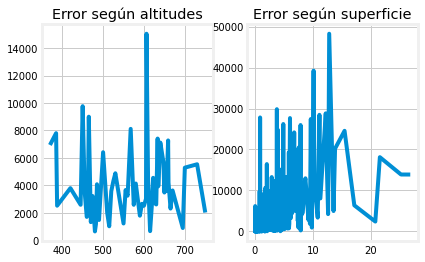

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(comp.groupby('altitud')['error_abs'].mean())
ax1.set_title('Error según altitudes')

ax2.plot(comp.groupby('superficie')['error_abs'].mean())
ax2.set_title('Error según superficie')

plt.show()

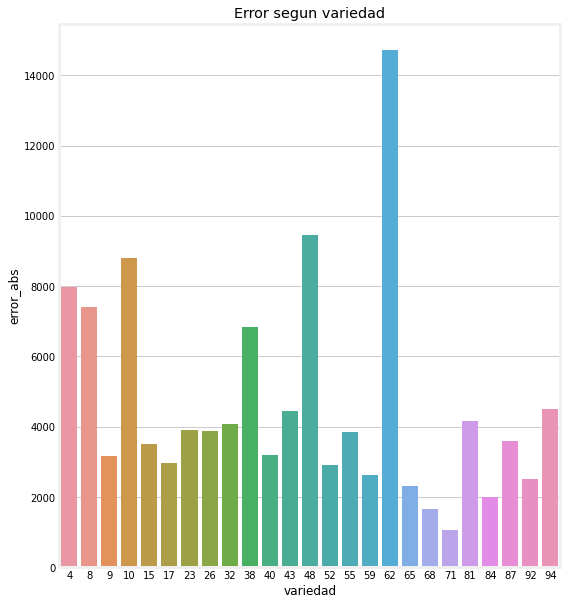

In [101]:
plt.figure(figsize=(8,10))
sns.barplot(data=comp.groupby('variedad')['error_abs'].mean().reset_index(), x='variedad',y='error_abs')
plt.title('Error segun variedad')
plt.show()